In [204]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [205]:
player_df = pd.read_csv('player_ids.csv')

player_df.head()

,player_name,dg_id
0,"Echavarria, Nico",22833
1,"Finau, Tony",11676
2,"Hoge, Tom",15575
3,"Rose, Justin",6093
4,"Putnam, Andrew",14704


In [206]:
player_df['player_name'] = player_df['player_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]))

In [207]:
player_df.head()

,player_name,dg_id
0,Nico Echavarria,22833
1,Tony Finau,11676
2,Tom Hoge,15575
3,Justin Rose,6093
4,Andrew Putnam,14704


In [208]:
owgr_df = pd.read_csv('OWGR_Top200_2024.csv')

owgr_df.head()

,Rank,Name
0,1,Scottie Scheffler
1,2,Xander Schauffele
2,3,Rory McIlroy
3,4,Collin Morikawa
4,5,Ludvig Aberg


In [209]:
player_df = player_df.merge(owgr_df, left_on='player_name', right_on='Name', how='inner')

In [210]:
player_df = player_df.dropna(subset=['Rank'])

In [211]:
player_df = player_df[player_df.Rank <= 100]

In [212]:
player_df.head()

,player_name,dg_id,Rank,Name
0,Tony Finau,11676,26,Tony Finau
1,Tom Hoge,15575,67,Tom Hoge
2,Justin Rose,6093,47,Justin Rose
4,Matt Wallace,20706,61,Matt Wallace
5,Denny McCarthy,19870,44,Denny McCarthy


In [213]:
PCA = pd.read_csv('PCA_output.csv')

PCA = PCA.drop(columns=[col for col in PCA.columns if col.startswith('sg_')])

PCA.head()

,dg_id,season,PC1,PC2
0,44,2024,-4.027681,2.995625
1,612,2024,-2.683059,0.823260
2,653,2024,-1.239911,-0.665933
3,863,2024,-4.741681,0.614116
4,874,2024,-7.396800,0.041895


In [214]:
PCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dg_id   644 non-null    int64  
 1   season  644 non-null    int64  
 2   PC1     644 non-null    float64
 3   PC2     644 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 20.3 KB


In [215]:
PCA = PCA[PCA['dg_id'].isin(player_df['dg_id'])].reset_index(drop=True)

In [216]:
PCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dg_id   95 non-null     int64  
 1   season  95 non-null     int64  
 2   PC1     95 non-null     float64
 3   PC2     95 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 3.1 KB


In [217]:
# pc_cols = ["PC1", "PC2"]

# scaler = StandardScaler()
# PCA[pc_cols] = scaler.fit_transform(PCA[pc_cols])

In [218]:
# PCA.drop(columns=["year"], inplace=True)

In [219]:
PCA.head()

,dg_id,season,PC1,PC2
0,6093,2024,0.458632,0.706524
1,6430,2024,1.209721,0.346004
2,7399,2024,0.849410,0.300865
3,8825,2024,0.820579,0.760437
4,9771,2024,0.844675,0.864263


In [220]:
key_cols = ['dg_id', 'season']

# X = PCA[["ott_ratio","app_ratio","arg_ratio","putt_ratio","driving_dist","driving_acc","gir"]]
X = PCA[["PC1", "PC2"]]

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

In [221]:
k_min, k_max = 2, 8
ks, inertias, sils = [], [], []
best_k, best_sil = None, -1

for k in range(k_min, k_max + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = km.fit_predict(Xz)
    
    if len(np.unique(labels)) < 2 or min((labels == c).sum() for c in np.unique(labels)) < 2:
        sil = -1.0
    else:
        sil = silhouette_score(Xz, labels)
        
    ks.append(k)
    inertias.append(km.inertia_)
    sils.append(sil)
    if sil > best_sil:
        best_k, best_sil = k, sil
        
best_k, best_sil

(3, 0.34341076100508805)

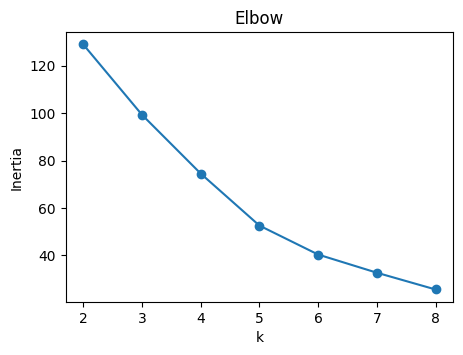

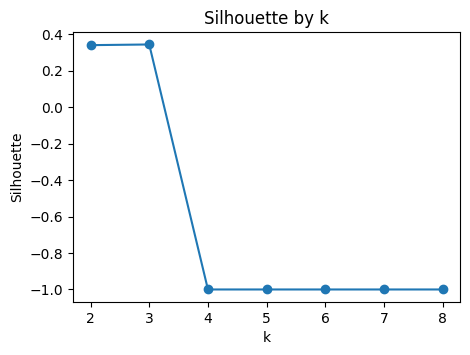

In [222]:
plt.figure(figsize=(5,3.5))
plt.plot(ks, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.show()

plt.figure(figsize=(5,3.5))
plt.plot(ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette by k")
plt.show()

In [223]:
km = KMeans(n_clusters=3, n_init=10, random_state=0)
labels = km.fit_predict(Xz)

clusters_df = PCA.copy()
clusters_df["cluster"] = labels
clusters_df["cluster"].value_counts().sort_index()

cluster
0    31
1    33
2    31
Name: count, dtype: int64

In [224]:
clusters_df["cluster"] = labels
cluster_means = clusters_df.groupby("cluster")[X.columns].mean().round(2)
print(cluster_means)

          PC1   PC2
cluster            
0        1.33 -0.31
1        0.57  0.09
2        0.98  0.71


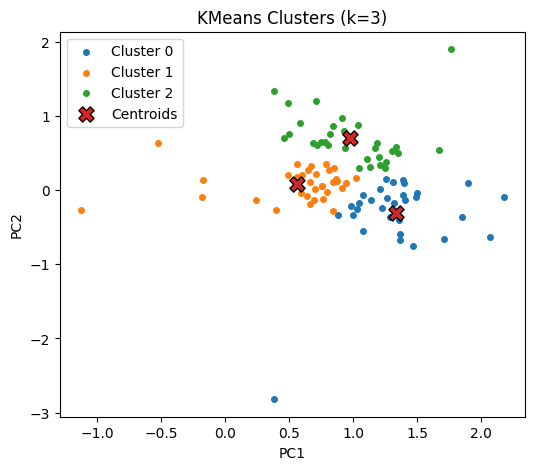

In [225]:
plt.figure(figsize=(6,5))
for c in np.unique(labels):
    m = labels == c
    plt.scatter(PCA["PC1"][m], PCA["PC2"][m], s=16, label=f"Cluster {c}")

# Plot cluster centers (transform back to original scale for PC1/PC2 only)
centers_z = km.cluster_centers_
# Only the first two columns correspond to PC1/PC2 if feature_cols starts with them:
if feature_cols[:2] == ["PC1", "PC2"]:
    centers_xy = scaler.inverse_transform(
        np.column_stack([centers_z[:, :2], np.zeros((centers_z.shape[0], len(feature_cols)-2))])
    )[:, :2]
    plt.scatter(centers_xy[:,0], centers_xy[:,1], marker="X", s=120, edgecolor="k", label="Centroids")

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k=3)")
plt.legend()
plt.show()

In [226]:
merged_clusters = clusters_df.merge(player_df, on="dg_id", how="inner")

In [227]:
merged_clusters.nsmallest(15, 'Rank')

,dg_id,season,PC1,PC2,cluster,player_name,Rank,Name
54,18417,2024,2.176025,-0.093982,0,Scottie Scheffler,1,Scottie Scheffler
65,19895,2024,1.671073,0.541910,2,Xander Schauffele,2,Xander Schauffele
5,10091,2024,1.496910,-0.036228,0,Rory McIlroy,3,Rory McIlroy
73,22085,2024,0.936131,0.565570,2,Collin Morikawa,4,Collin Morikawa
83,23950,2024,1.317619,-0.165432,0,Ludvig Aberg,5,Ludvig Aberg
19,13562,2024,1.259471,0.150320,0,Hideki Matsuyama,6,Hideki Matsuyama
81,23604,2024,1.211862,0.018723,0,Wyndham Clark,7,Wyndham Clark
58,18841,2024,1.402586,-0.126339,0,Viktor Hovland,8,Viktor Hovland
11,12294,2024,0.779839,0.648160,2,Tommy Fleetwood,9,Tommy Fleetwood
63,19841,2024,0.911441,0.035855,1,Bryson DeChambeau,10,Bryson DeChambeau


In [228]:
highlighted_players = ["Bryson DeChambeau", "Rory McIlroy", "Tommy Fleetwood", "Justin Thomas"]

dg_ids = merged_clusters[merged_clusters["player_name"].isin(highlighted_players)]["dg_id"].values

In [229]:
dg_ids

array([10091, 12294, 14139, 19841])

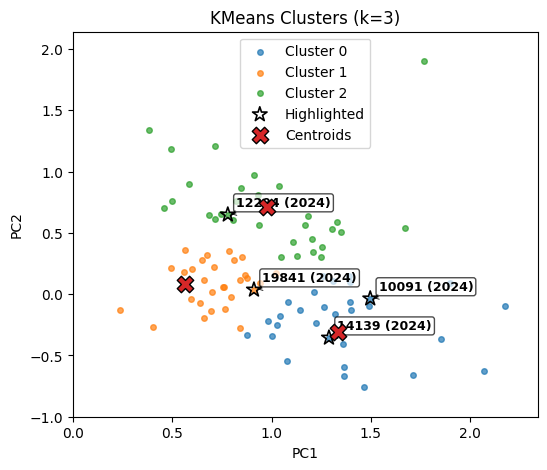

In [230]:
# ids you want to call out
highlight_ids = dg_ids  # <- change this

# if your plotted DataFrame is PCA and labels align 1:1:
plot_df = PCA.copy()
plot_df["cluster"] = labels

plt.figure(figsize=(6,5))
for c in np.unique(labels):
    m = plot_df["cluster"] == c
    plt.scatter(plot_df.loc[m, "PC1"], plot_df.loc[m, "PC2"], s=16, label=f"Cluster {c}", alpha=0.7)

# overlay highlights (thicker edge, bigger marker)
hl = plot_df["dg_id"].isin(highlight_ids)
plt.scatter(plot_df.loc[hl, "PC1"], plot_df.loc[hl, "PC2"],
            s=120, marker="*", edgecolor="k", linewidths=1.2, facecolors="none", zorder=5, label="Highlighted")

# annotate each highlighted point
for _, r in plot_df.loc[hl, ["dg_id","season","PC1","PC2"]].iterrows():
    plt.annotate(f"{int(r.dg_id)} ({int(r.season)})",  # text: dg_id (season)
                 (r.PC1, r.PC2),
                 xytext=(6,6), textcoords="offset points",
                 fontsize=9, weight="bold",
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
                 arrowprops=dict(arrowstyle="->", lw=0.6))

# (optional) plot centroids if you computed centers_xy
try:
    plt.scatter(centers_xy[:,0], centers_xy[:,1], marker="X", s=140, edgecolor="k", zorder=6, label="Centroids")
except NameError:
    pass

plt.xlim(left=0)      # PC1 >= 0 on the x-axis
plt.ylim(bottom=-1)   # PC2 >= -1 on the y-axis

plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k})")
plt.legend()
plt.show()


In [231]:
merged_clusters[merged_clusters["dg_id"].isin(dg_ids)]

,dg_id,season,PC1,PC2,cluster,player_name,Rank,Name
5,10091,2024,1.496910,-0.036228,0,Rory McIlroy,3,Rory McIlroy
11,12294,2024,0.779839,0.648160,2,Tommy Fleetwood,9,Tommy Fleetwood
23,14139,2024,1.289165,-0.355800,0,Justin Thomas,19,Justin Thomas
63,19841,2024,0.911441,0.035855,1,Bryson DeChambeau,10,Bryson DeChambeau


In [232]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

key_cols = ['dg_id', 'season', 'year']

feature_cols = [col for col in PCA.columns if col not in key_cols]

print(feature_cols)

# X = PCA[["ott_ratio","app_ratio","arg_ratio","putt_ratio","driving_dist","driving_acc","gir"]]
# X = PCA[feature_cols]
X = PCA[["PC1", "PC2"]]

print(X)
X_scaled = StandardScaler().fit_transform(X)

scores = []
for k in range(2, 8):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

print(scores)

['PC1', 'PC2']
         PC1       PC2
0   0.458632  0.706524
1   1.209721  0.346004
2   0.849410  0.300865
3   0.820579  0.760437
4   0.844675  0.864263
..       ...       ...
90  0.702786  0.017446
91  1.389266  0.144691
92  0.767044 -0.122929
93  1.896747  0.091505
94  1.851190 -0.365973

[95 rows x 2 columns]
[(2, 0.5285323722102563), (3, 0.4780301202846387), (4, 0.3048771587505207), (5, 0.3039502439641826), (6, 0.3233651859125339), (7, 0.3504330963374592)]


In [233]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
labels = gmm.fit_predict(X_scaled)

clusters_df = PCA.copy()
clusters_df["cluster"] = labels
clusters_df["cluster"].value_counts().sort_index()

cluster
0    24
1     2
2     4
3    65
Name: count, dtype: int64

In [234]:
clusters_df["cluster"] = labels
cluster_means = clusters_df.groupby("cluster")[X.columns].mean().round(2)
print(cluster_means)

          PC1   PC2
cluster            
0        0.76  0.68
1        0.38 -0.74
2       -0.50  0.10
3        1.13 -0.00


In [235]:
merged_clusters = clusters_df.merge(player_df, on="dg_id", how="inner")

In [236]:
merged_clusters.nsmallest(15, 'Rank')

,dg_id,season,PC1,PC2,cluster,player_name,Rank,Name
54,18417,2024,2.176025,-0.093982,3,Scottie Scheffler,1,Scottie Scheffler
65,19895,2024,1.671073,0.541910,3,Xander Schauffele,2,Xander Schauffele
5,10091,2024,1.496910,-0.036228,3,Rory McIlroy,3,Rory McIlroy
73,22085,2024,0.936131,0.565570,0,Collin Morikawa,4,Collin Morikawa
83,23950,2024,1.317619,-0.165432,3,Ludvig Aberg,5,Ludvig Aberg
19,13562,2024,1.259471,0.150320,3,Hideki Matsuyama,6,Hideki Matsuyama
81,23604,2024,1.211862,0.018723,3,Wyndham Clark,7,Wyndham Clark
58,18841,2024,1.402586,-0.126339,3,Viktor Hovland,8,Viktor Hovland
11,12294,2024,0.779839,0.648160,0,Tommy Fleetwood,9,Tommy Fleetwood
63,19841,2024,0.911441,0.035855,3,Bryson DeChambeau,10,Bryson DeChambeau
